In [20]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [37]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('feb05list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['TSN','JD']
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2017-12-14'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [28]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [29]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df, etf

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-01-29    6.31         -0.03    -0.004743   0.005692          0.035917   
2018-01-30    5.49         -0.82    -0.139207   0.070587          0.387525   
2018-01-31    5.06         -0.43    -0.081562   0.068991          0.349096   
2018-02-01    5.00         -0.06    -0.011929   0.063512          0.317559   
2018-02-02    4.76         -0.24    -0.049190   0.053938          0.256743   

            price_dev  annual_vol  
Date                               
2018-01-29  -0.675140    0.090359  
2018-01-30 -22.830350    1.120542  
2018-01-31  -1.109605    1.095202  
2018-02-01  -0.171873    1.008220  
2018-02-02  -0.755764    0.856233  
---------------------
Date of largest drop
-22.8303504661
2018-01-30 00:00:00
---------------------
Date of largest spike
9.1637478536
2016-11-09 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


-0.20072292755946428

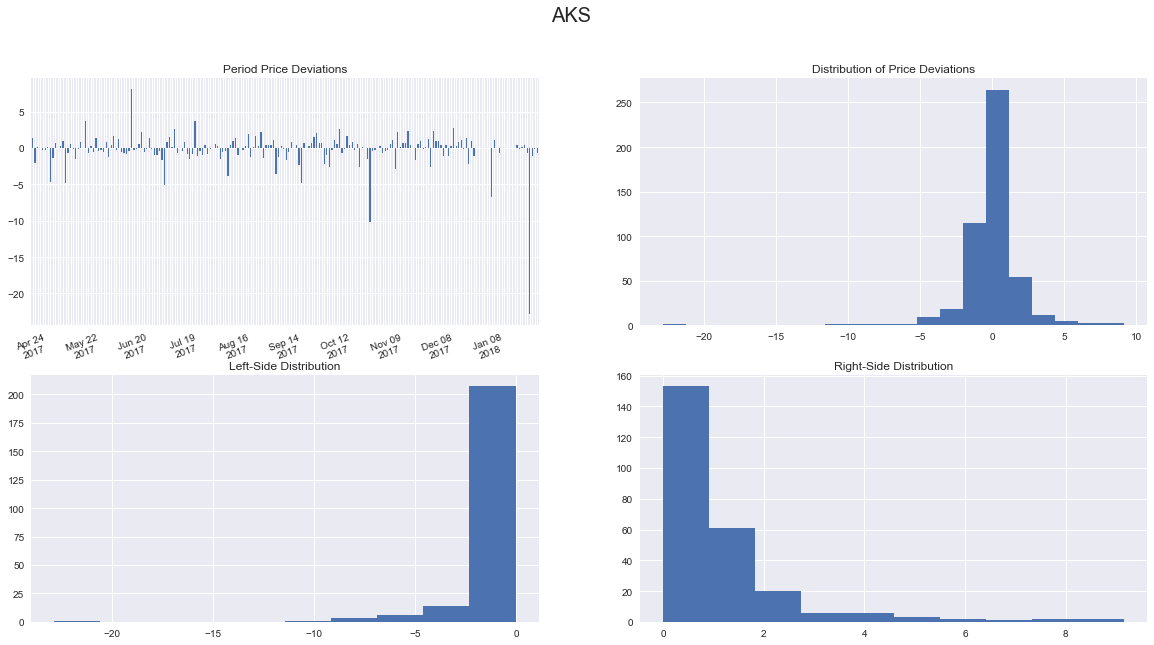

In [13]:
rolling_period = 4
lookback_window = 200
hist_window = 500
ticker = 'AKS'
summary, full_df = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)
full_df['price_dev'].dropna().skew()

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-01-29  60.959999     -0.880001    -0.014333   0.010045          0.612336   
2018-01-30  59.750000     -1.209999    -0.020049   0.012224          0.730412   
2018-01-31  60.049999      0.299999     0.005008   0.013220          0.793843   
2018-02-01  61.369999      1.320000     0.021744   0.019067          1.170160   
2018-02-02  59.110001     -2.259998    -0.037521   0.026269          1.552770   

            price_dev  annual_vol  
Date                               
2018-01-29  -4.754864    0.159458  
2018-01-30  -1.976038    0.194057  
2018-01-31   0.410726    0.209856  
2018-02-01   1.662796    0.302684  
2018-02-02  -1.931358    0.417010  
---------------------
Date of largest drop
-7.96619455943
2017-04-27 00:00:00
---------------------
Date of largest spike
7.3395808424
2017-09-21 00:00:00
---------------------
   

KeyError: '[ nan] not in index'

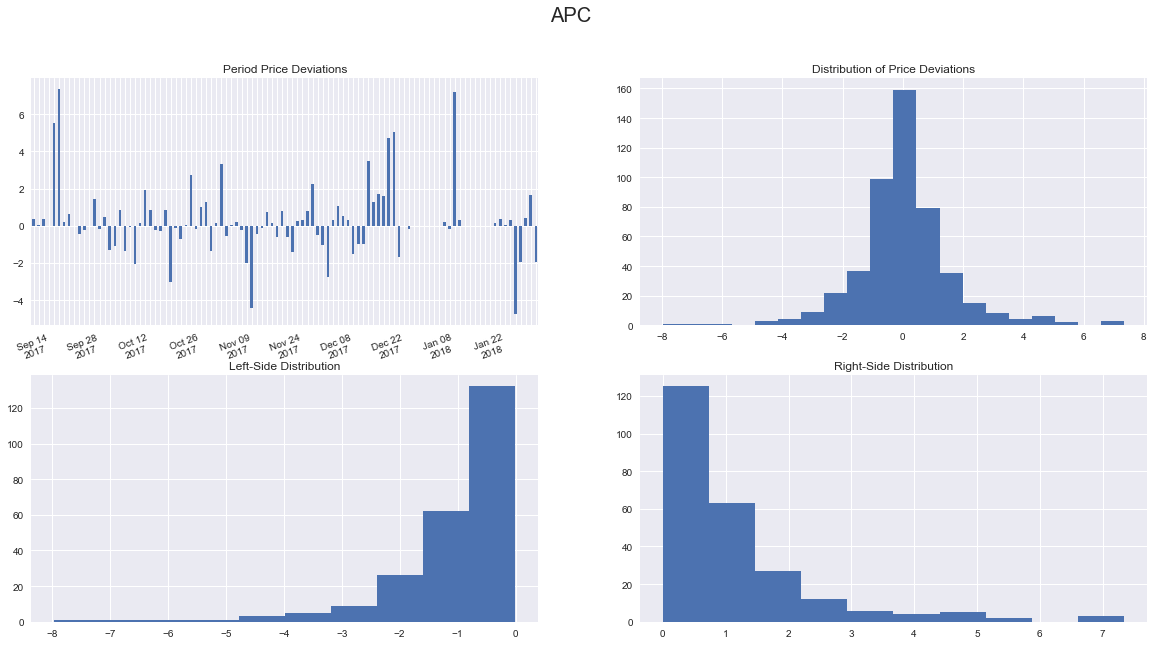

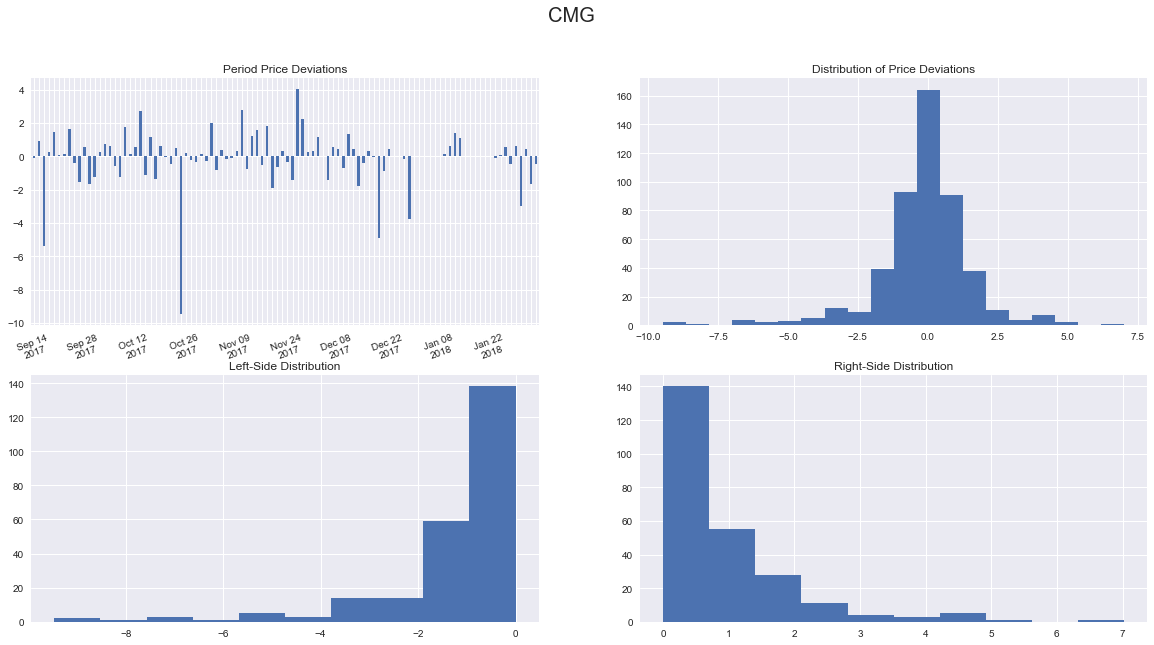

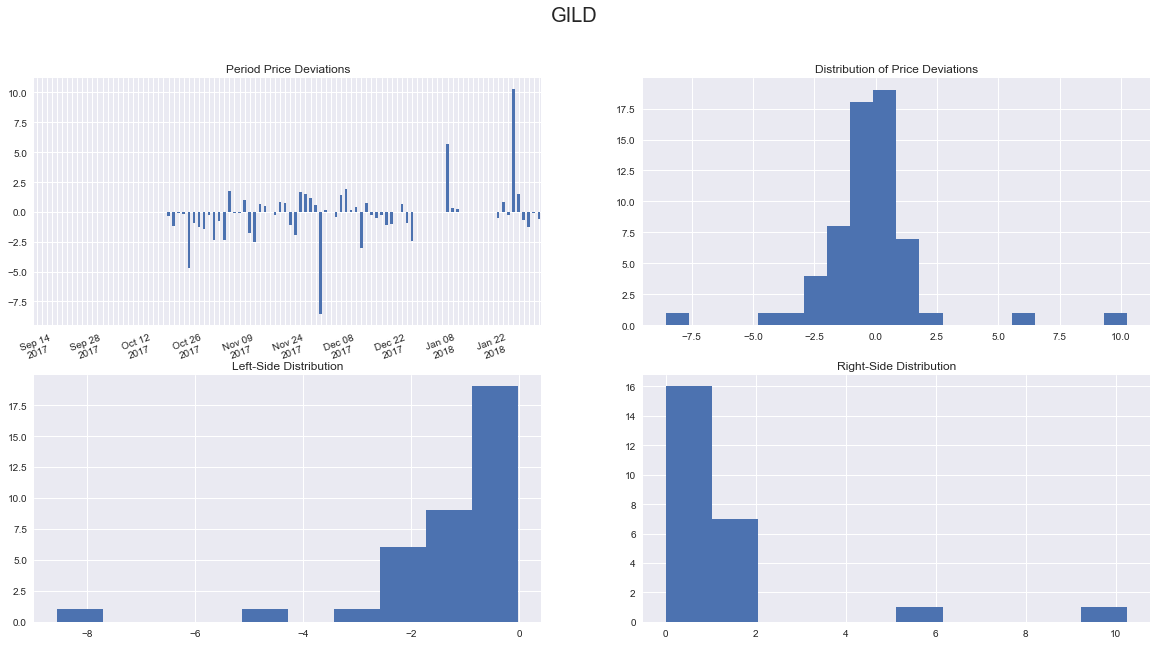

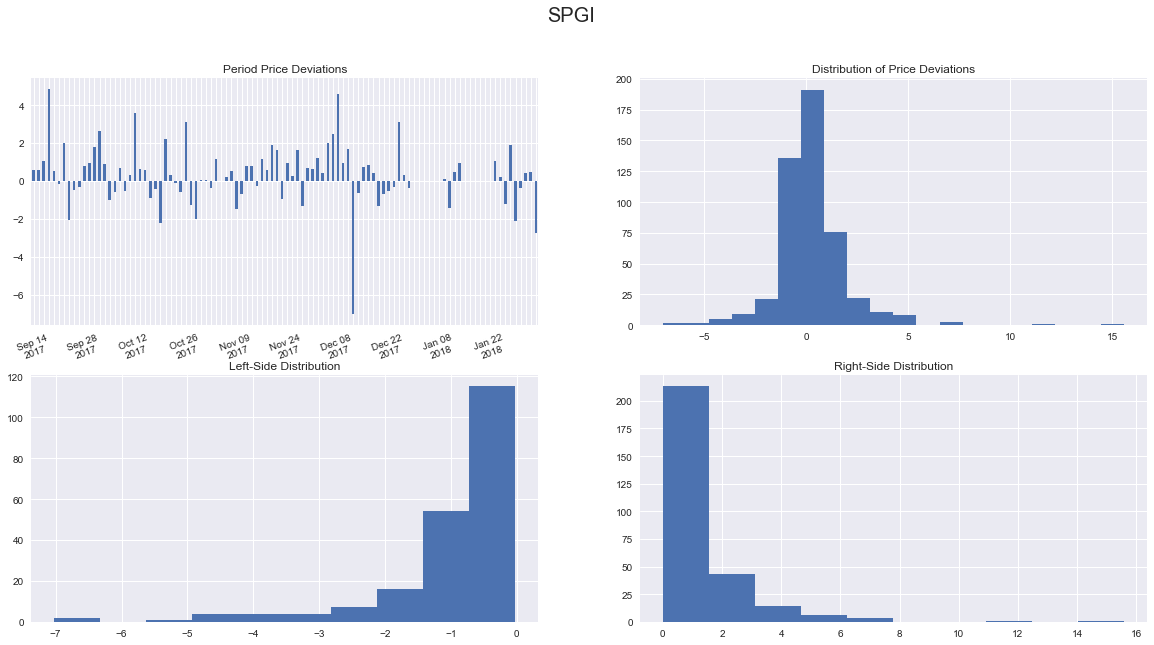

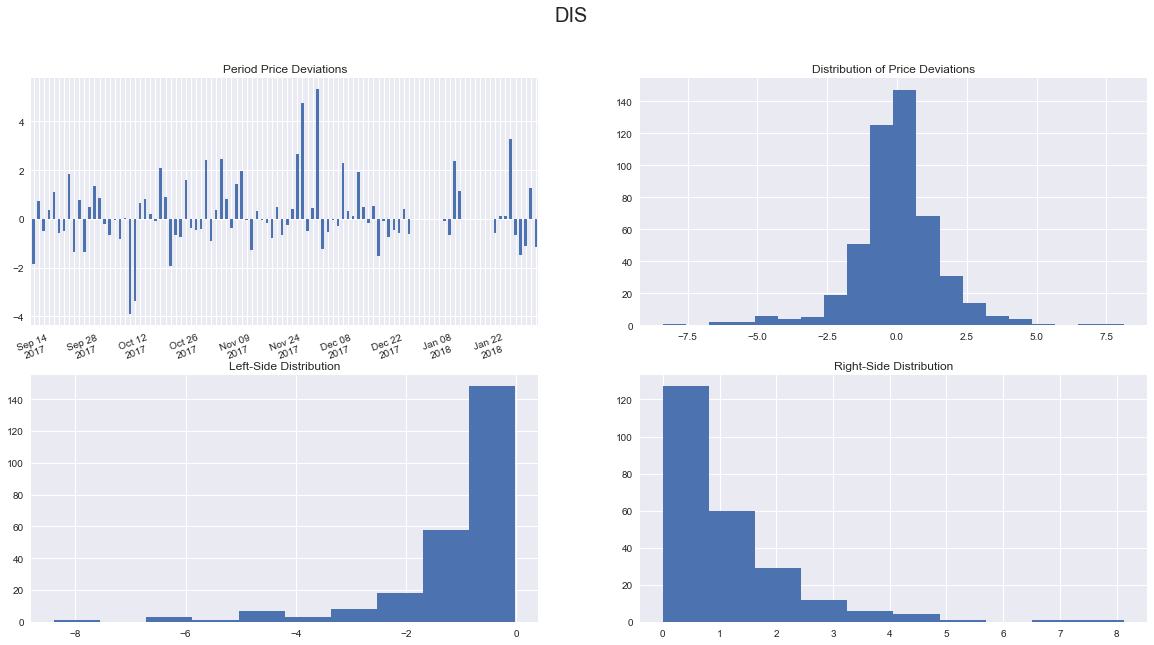

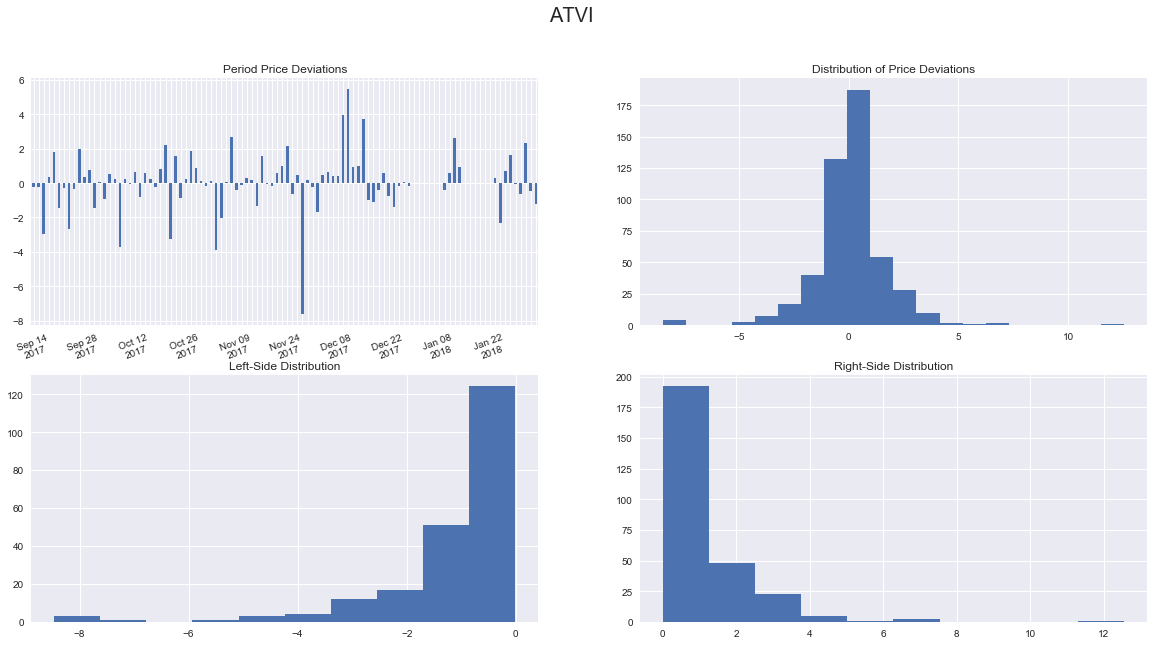

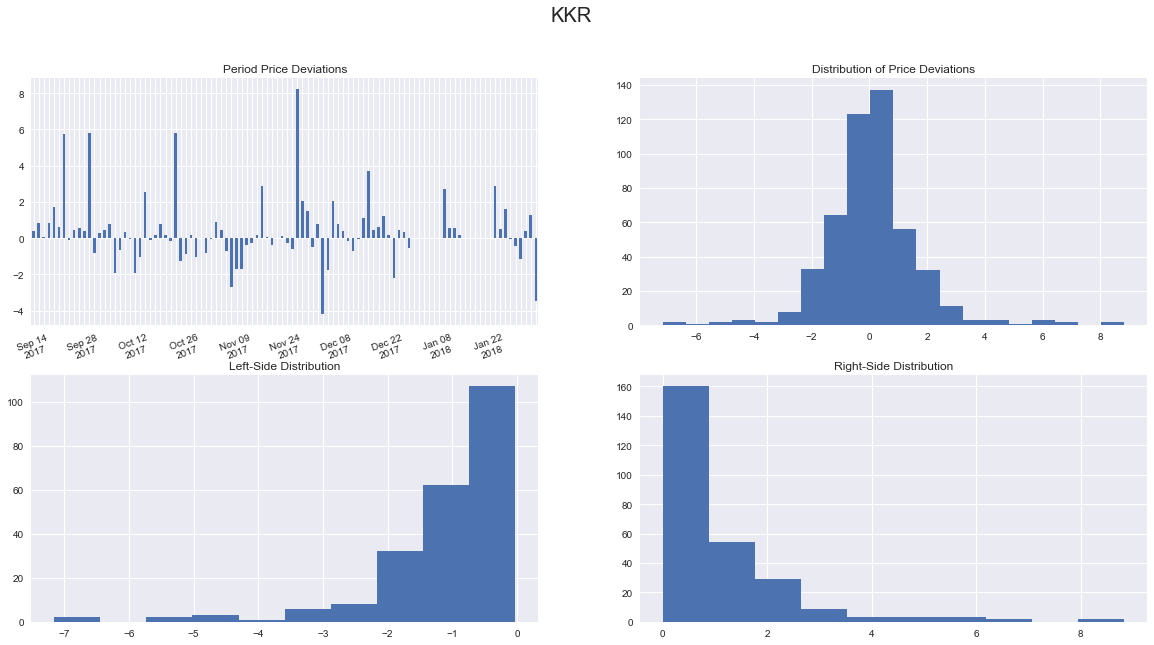

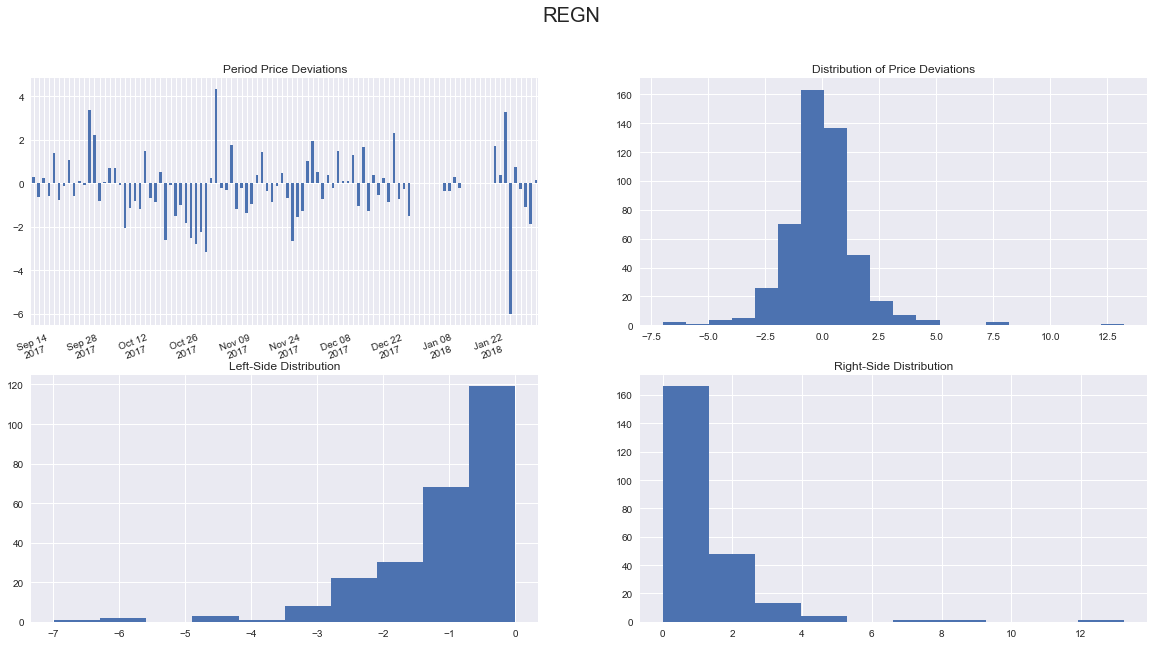

In [33]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [38]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,59.110001,APC
1,311.640015,CMG
2,81.730003,GILD
3,177.330002,SPGI
4,108.699997,DIS
5,71.419998,ATVI
6,23.480000,KKR
7,347.859985,REGN


In [14]:
full_df['price_dev'].dropna().skew()

0.75157125093740373

In [15]:
full_df['price_dev'].dropna().describe()

count    2605.000000
mean        0.057219
std         1.819942
min       -11.782973
25%        -0.655835
50%         0.013202
75%         0.782285
max        24.518553
Name: price_dev, dtype: float64

In [28]:
std_thresh = 4

down_nums = summary[summary.index <= -std_thresh].sum()
up_nums = summary[summary.index >= std_thresh].sum()

print("Threshold stdev: {0} \nNumber of deviations downward: {1} \nNumber of deviations upward: {2}".format(std_thresh,
                                                                                                           down_nums,
                                                                                                           up_nums))

Threshold stdev: 4 
Number of deviations downward: Frequency    7
dtype: int64 
Number of deviations upward: Frequency    10
dtype: int64


In [16]:
full_df.to_csv('avgo.csv')

In [19]:
min(summary[summary['Frequency'] != 0].index) <= -10

True